# Digigt Recognizer

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotly.express as px
from tqdm.notebook import tqdm
from IPython.display import clear_output

### Посмотрим на данные

In [2]:
data = pd.read_csv('data/train.csv')
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [4]:
data.isna().sum().sum()

np.int64(0)

In [5]:
data.max().max(), data.min().min()

(np.int64(255), np.int64(0))

#### Пропусков нет, значения от 0 до 255 - поместится в uint8

In [6]:
data = pd.read_csv('data/train.csv', dtype=np.uint8)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: uint8(785)
memory usage: 31.4 MB


##### Баланс классов

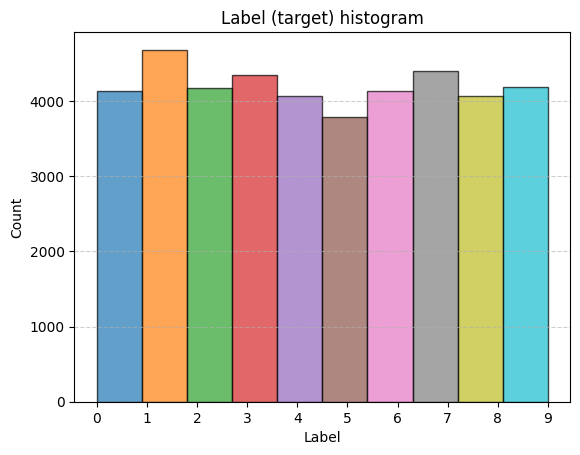

In [7]:
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
]

counts, bins = np.histogram(data['label'], bins=10)
plt.bar(bins[:-1], counts, width=np.diff(bins), align='edge', color=colors[:len(counts)], edgecolor='black', alpha=0.7)
plt.xlabel('Label')
plt.xticks([i for i in range(10)])
plt.ylabel('Count')
plt.title('Label (target) histogram')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

#### Посмотрим на изображения

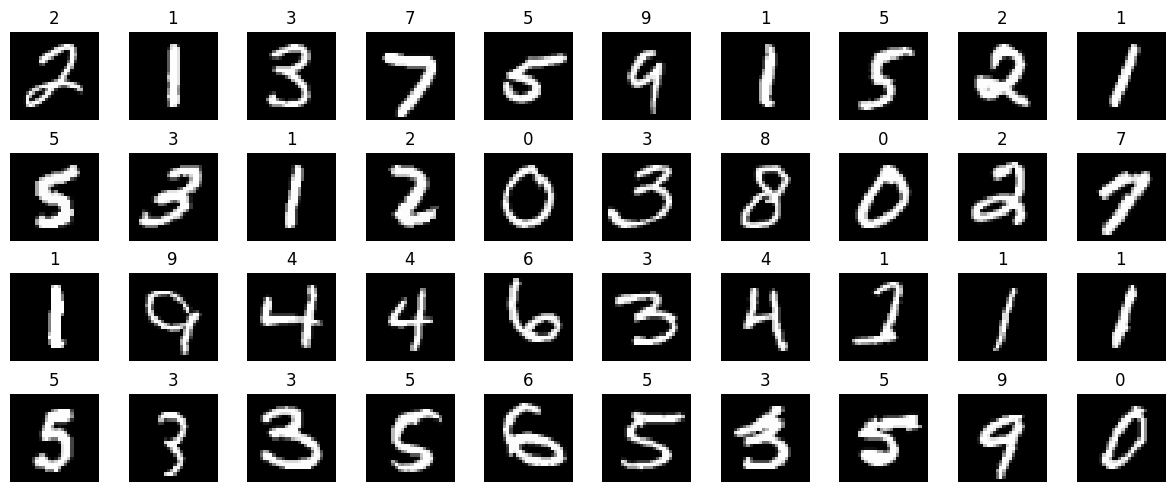

In [8]:
_, axes = plt.subplots(4, 10, figsize=(12, 5))
for ax in axes.flatten():
    image = data.iloc[np.random.randint(0, len(data))].copy()
    ax.imshow(image.drop('label').to_numpy().reshape((28, 28)), cmap='gray')
    ax.set_title(image['label'])
    ax.axis('off')
plt.tight_layout()
plt.show()

#### Распределение значений пикселей

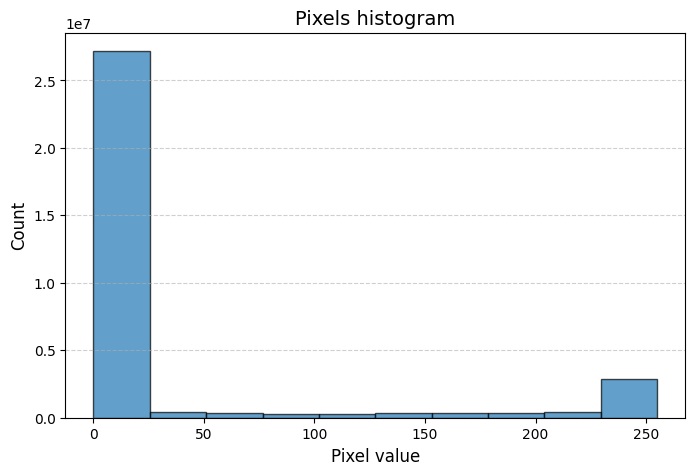

In [9]:
plt.figure(figsize=(8,5))
plt.hist(data.drop('label', axis=1).values.flatten(), edgecolor='black', alpha=0.7)
plt.title('Pixels histogram', fontsize=14)
plt.xlabel('Pixel value', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

#### Посмотрим на "среднего" представителя каждого класса

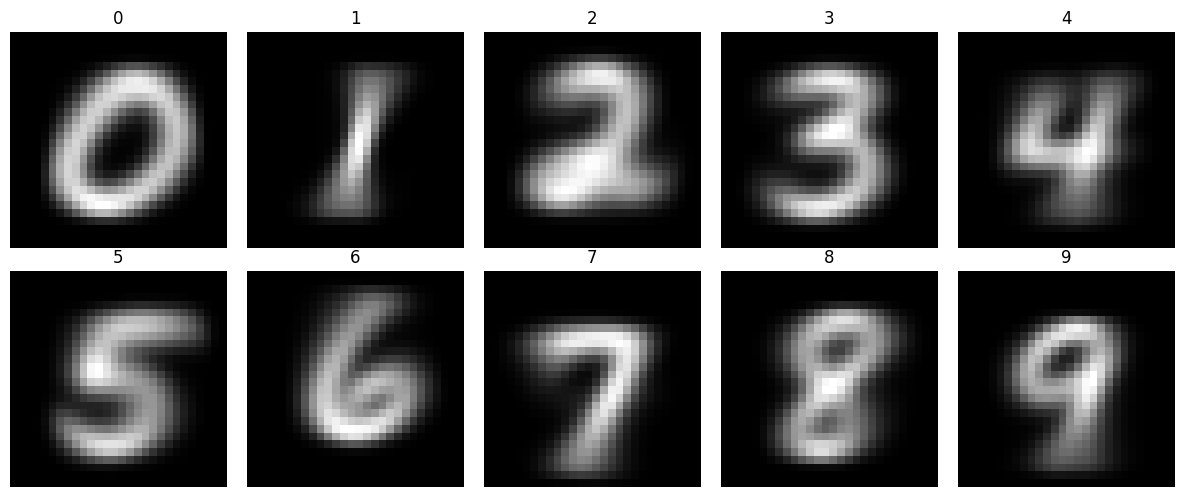

In [10]:
_, axes = plt.subplots(2, 5, figsize=(12, 5))
for label, ax in enumerate(axes.flatten()):
    mean_image = data[data['label'] == label].drop('label', axis=1).mean().values.reshape(28,28)
    ax.imshow(mean_image, cmap='gray')
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()

#### Визуализируем данные в 2D и 3D

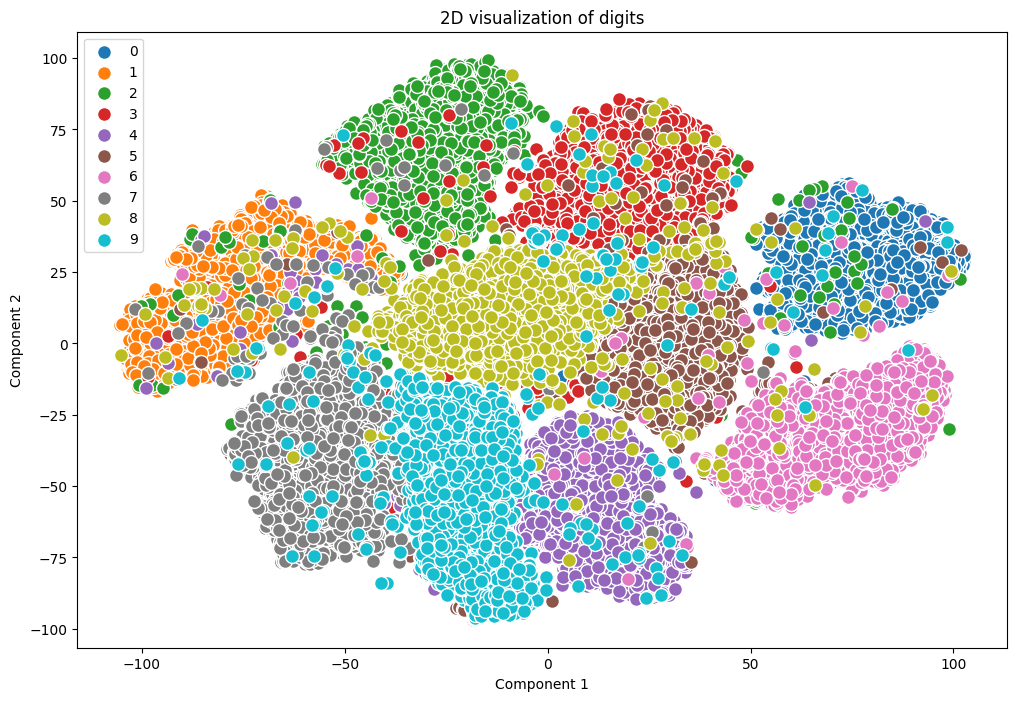

In [31]:
tsnedata = TSNE(n_components=2, random_state=33, n_jobs=-1).fit_transform(data.drop('label', axis=1))
plt.figure(figsize=(12, 8))
for label in np.unique(data['label']):
    plt.scatter(tsnedata[data['label'] == label, 0], tsnedata[data['label'] == label, 1], label=f'{label}', edgecolors='w', s=100, color=colors[label])
plt.title('2D visualization of digits')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [ ]:
tsnedata = TSNE(n_components=3, random_state=33, n_jobs=-1).fit_transform(data.drop('label', axis=1))
px.scatter_3d(x=tsnedata[:, 0], y=tsnedata[:, 1], z=tsnedata[:, 2], color=data['label'], labels={'color': 'label'}, title='3D visualization of digits', width=800, height=600).show()

#### Разделим данные

In [11]:
train, test = train_test_split(data, test_size=0.3, random_state=33)
X_train, y_train = train.drop('label', axis=1), train['label']
X_test, y_test = test.drop('label', axis=1), test['label']

#### Baseline 1 - KNN

In [12]:
knn = KNeighborsClassifier(10)
knn.fit(X_train / 255.0, y_train)

print(f'KNN train accuracy {accuracy_score(y_train, knn.predict(X_train / 255.0)):.2f}')
print(f'KNN test accuracy {accuracy_score(y_test, knn.predict(X_test / 255.0)):.2f}')

KNN train accuracy 0.97
KNN test accuracy 0.96


#### Baseline 2 - RandomForest

In [13]:
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train, y_train)

print(f'RandomForest train accuracy {accuracy_score(y_train, rf.predict(X_train)):.2f}')
print(f'RandomForest test accuracy {accuracy_score(y_test, rf.predict(X_test)):.2f}')

RandomForest train accuracy 1.00
RandomForest test accuracy 0.97


#### Без каких либо преобразований и добавления новых данных можно добиться 96% с простым алгоритмом KNN и чуть больше с более сложным алгоритмом - RandomForest

### Аугментируем и преобразуем данные

In [12]:
len(train), len(test) # не подходит, тк будем хранить преобразования в памяти

(29400, 12600)

In [13]:
train, test_and_val = train_test_split(data, train_size=0.33, random_state=33, stratify=data['label'])
test, val = train_test_split(test_and_val, test_size=0.3, random_state=33, stratify=test_and_val['label'])

In [14]:
total = len(train) * 4 + len(test) + len(val)
print(f'train (augmented): {len(train) * 4 / total:.2%}, test: {len(test) / total:.2%}, val: {len(val) / total:.2%}')

train (augmented): 66.33%, test: 23.57%, val: 10.10%


In [15]:
def transform_data(train_labels, train_images, transform, transforms_num=3):
    augmented_images = []
    augmented_labels = []

    for img, lbl in zip(train_images, train_labels):
        augmented_images.append(transforms.ToTensor()(img))
        augmented_labels.append(lbl)
        for _ in range(transforms_num):
            aug_img = transform(img)
            augmented_images.append(aug_img)
            augmented_labels.append(lbl)

    X = torch.stack(augmented_images)
    y = F.one_hot(torch.tensor(augmented_labels, dtype=torch.long), num_classes=10)

    return X, y

In [16]:
train_labels = train['label'].to_numpy()
train_images = train.drop('label', axis=1).to_numpy().reshape(-1, 28, 28)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x))
])

X_train, y_train = transform_data(train_labels, train_images, transform, transforms_num=3)

In [17]:
test_labels = test['label'].to_numpy()
test_images = test.drop('label', axis=1).to_numpy().reshape(-1, 28, 28)


X_test, y_test = transform_data(test_labels, test_images, None, transforms_num=0)

val_labels = val['label'].to_numpy()
val_images = val.drop('label', axis=1).to_numpy().reshape(-1, 28, 28)


X_val, y_val = transform_data(val_labels, val_images, None, transforms_num=0)

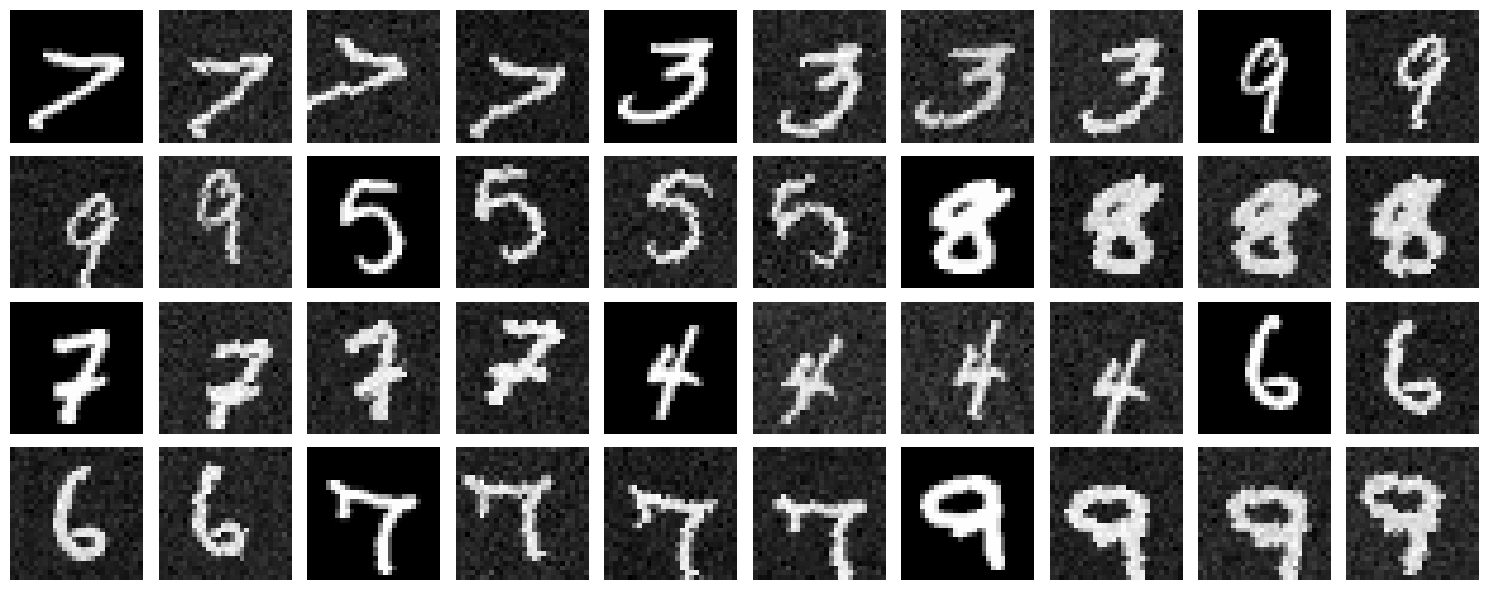

In [18]:
fig, axes = plt.subplots(4, 10, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [19]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

##### Архитектура

In [20]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            # nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.skip = nn.Conv2d(64, 128, kernel_size=1)

        self.fc = nn.Sequential(
            nn.Flatten(),
            # nn.Dropout(0.2), 
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x3 = x3 + self.skip(x2)
        x = self.fc(x3)
        return x

In [ ]:
def training_epoch(model, optimizer, criterion, train_loader, e, epochs, device):
    cnt, sum_loss = 0, 0
    total, correct = 0, 0
    tqdm_loader = tqdm(train_loader)
    model.train()
    for x_train, y_train in tqdm_loader:
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        preds = model(x_train)
        
        loss = criterion(preds, y_train.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += (preds.argmax(dim=1) == y_train.argmax(dim=1)).sum().item()
        total += len(y_train)
        sum_loss += loss.item()
        cnt += 1
        tqdm_loader.set_description(f"Epoch [{e + 1}/{epochs}], loss_mean={(sum_loss/cnt):.3f}")

    return sum_loss / cnt, correct / total

@torch.no_grad()
def validation_epoch(model, criterion, val_loader, device):
    model.eval()
    cnt, sum_loss = 0, 0
    total, correct = 0, 0
    for x_val, y_val in val_loader:
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        val_preds = model(x_val)
        loss = criterion(val_preds, y_val.float()).item()

        correct += (val_preds.argmax(dim=1) == y_val.argmax(dim=1)).sum().item()
        total += len(y_val)

        sum_loss += loss
        cnt += 1

    return sum_loss / cnt, correct / total


def training_plot(train_losses, val_losses, train_acc, val_acc, e):
    clear_output(True)
    fig = plt.figure(figsize=(10, 5))

    plt.plot(train_losses, label='Train loss')
    plt.plot(val_losses, label='Validation loss')
    plt.plot(train_acc, label='Train accuracy')
    plt.plot(val_acc, label='Validation accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training, epoch {e+1}')
    plt.show()

@torch.no_grad()
def predict(model, data_loader):
    model.eval()
    preds_list = []

    for X_batch, _ in data_loader:
        preds = model(X_batch)

        preds_list.append(preds.cpu())

    predicts = torch.cat(preds_list, dim=0)
    return predicts

def train(model, optimizer, criterion, train_loader, val_loader, epochs, device):
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    
    for e in range(epochs):
        train_loss, train_accuracy = training_epoch(model, optimizer, criterion, train_loader, e, epochs, device)

        val_loss, val_accuracy = validation_epoch(model, criterion, val_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)

        training_plot(train_losses, val_losses, train_acc, val_acc, e)
        print(f'Epoch [{e+1}/{epochs}] | loss: {train_loss:.3f} | accuracy: {train_accuracy:.3f} | val_loss: {val_loss:.3f} | val_accuracy: {val_accuracy:.3f}')
        torch.save(model.state_dict(), f=f'models/label_sm_epoch_{e+1}.tar')

    return model.eval()

In [30]:
device = torch.device('mps')
train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=128)
model = Model().eval()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
epochs = 35

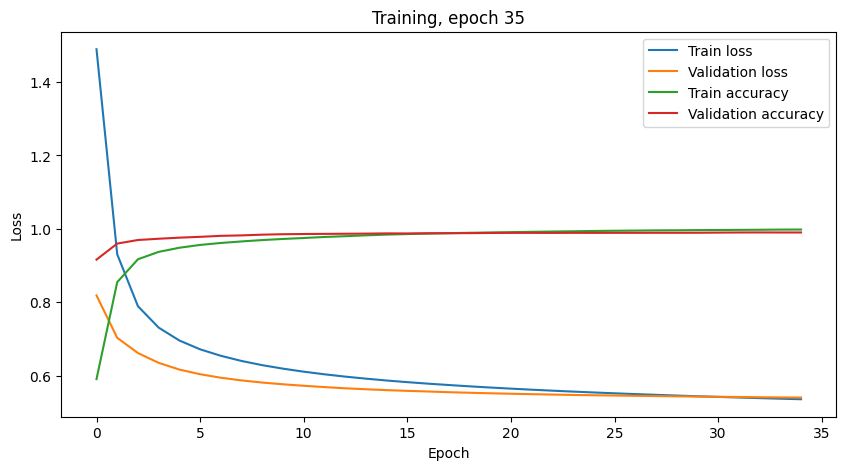

Epoch [35/35] | loss: 0.536 | accuracy: 0.998 | val_loss: 0.540 | val_accuracy: 0.990


Model(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [31]:
train(model, optimizer, criterion, train_dataloader, val_dataloader, epochs, device)

In [43]:
for i in range(35):
    model.load_state_dict(torch.load(f'models/label_sm_epoch_{i+1}.tar'))
    preds = model(X_test)
    predicted_labels = torch.softmax(preds, dim=1).argmax(dim=1).numpy()
    print(f'Model {i+1}: accuracy {accuracy_score(y_test.argmax(dim=1).numpy(), predicted_labels):.3f}')

Model 1: accuracy 0.915
Model 2: accuracy 0.962
Model 3: accuracy 0.970
Model 4: accuracy 0.974
Model 5: accuracy 0.978
Model 6: accuracy 0.980
Model 7: accuracy 0.981
Model 8: accuracy 0.982
Model 9: accuracy 0.984
Model 10: accuracy 0.985
Model 11: accuracy 0.986
Model 12: accuracy 0.986
Model 13: accuracy 0.987
Model 14: accuracy 0.987
Model 15: accuracy 0.988
Model 16: accuracy 0.988
Model 17: accuracy 0.988
Model 18: accuracy 0.989
Model 19: accuracy 0.989
Model 20: accuracy 0.989
Model 21: accuracy 0.989
Model 22: accuracy 0.990
Model 23: accuracy 0.990
Model 24: accuracy 0.990
Model 25: accuracy 0.990
Model 26: accuracy 0.990
Model 27: accuracy 0.990
Model 28: accuracy 0.991
Model 29: accuracy 0.991
Model 30: accuracy 0.991
Model 31: accuracy 0.991
Model 32: accuracy 0.991
Model 33: accuracy 0.991
Model 34: accuracy 0.991
Model 35: accuracy 0.991


#### Объединим модели 15, 16, ..., 30 в одну

In [195]:
from collections import Counter

class SuperModel():
    def __init__(self, models_nums, transforms_num=5, transforms=None,):
        self.models = []
        self.transforms_num = transforms_num
        self.transforms = transforms
        for i in models_nums:
            model = Model()
            model.load_state_dict(torch.load(f'models/label_sm_epoch_{i+1}.tar'))
            model.eval()
            self.models.append(model)

    @torch.no_grad
    def __predict_one__(self, X):
        X = X.reshape(-1, 1, 28, 28)
        probs = torch.zeros(size=(10,))
        for m in self.models:
            probs = probs + torch.softmax(m(X).squeeze(), dim=0)
        return torch.softmax(probs, dim=0).argmax()
    
    @torch.no_grad
    def __predict_for_transforms__(self, X):
        labels = []
        for i in range(self.transforms_num):
            transim = self.transforms(X) if i != 0 else transforms.ToTensor()(X)
            labels.append(self.__predict_one__(transim))
        c = Counter(labels)
        return c.most_common()[0][0]
    
    @torch.no_grad
    def predict(self, X):
        labels = []
        for x in X:
            labels.append(self.__predict_for_transforms__(x))
        return labels
    

In [ ]:
sm = SuperModel(
    models_nums=[i for i in range(17, 35)], 
    transforms_num=6, 
    transforms=transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x))
    ])
)

In [165]:
preds = sm.predict(test.drop('label', axis=1).to_numpy().reshape(-1, 28, 28))

In [166]:
answs = test['label'].to_numpy()

In [167]:
accuracy_score(answs, preds)

0.9895420854909128

In [193]:
sm2 = SuperModel(
    models_nums=[34], 
    transforms_num=6, 
    transforms=transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x))
    ]),
)
preds2 = sm2.predict(test.drop('label', axis=1).to_numpy().reshape(-1, 28, 28))
answs2 = test['label'].to_numpy()
accuracy_score(answs2, preds2)

0.9909127830236573

#### Объединение не дает лучших результатов, так как модели сильно похожи, выгоднее использовать одну модель

In [199]:
submiss_data = pd.read_csv('data/test.csv')
submiss_data = submiss_data.to_numpy().reshape(-1, 28, 28).astype(np.uint8)
submiss_data.shape

(28000, 28, 28)

##### Попробуем без преобразований

In [ ]:
sm3 = SuperModel(
    models_nums=[34], 
    transforms_num=1, 
    transforms=None
)
sub_preds1 = sm3.predict(submiss_data)
sub_preds1 = np.array([x.item() for x in sub_preds1])

In [212]:
df = pd.DataFrame({
    'ImageId': range(1, len(sub_preds1) + 1),
    'Label': sub_preds1
})
df.to_csv('submission_sm3.csv', index=False)

##### И с преобразованиями

In [213]:
sub_preds2 = sm2.predict(submiss_data)

In [215]:
sub_preds2 = np.array([x.item() for x in sub_preds2])
df2 = pd.DataFrame({
    'ImageId': range(1, len(sub_preds2) + 1),
    'Label': sub_preds2
})
df2.to_csv('submission_sm2.csv', index=False)

#### Обе посылки дали одинаковый результат - 0.99003 accuracy